# RLE - Mini challenge

Rami | @r9119

In [1]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import ale_py
import torch.nn.functional as F
import math

gym.register_envs(ale_py)

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Create the environment
env = gym.make("ALE/SpaceInvaders-v5")

# Define our Transition named tuple for experience replay
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

Evaluating Random Agent: 100%|██████████| 250/250 [00:39<00:00,  6.31it/s]


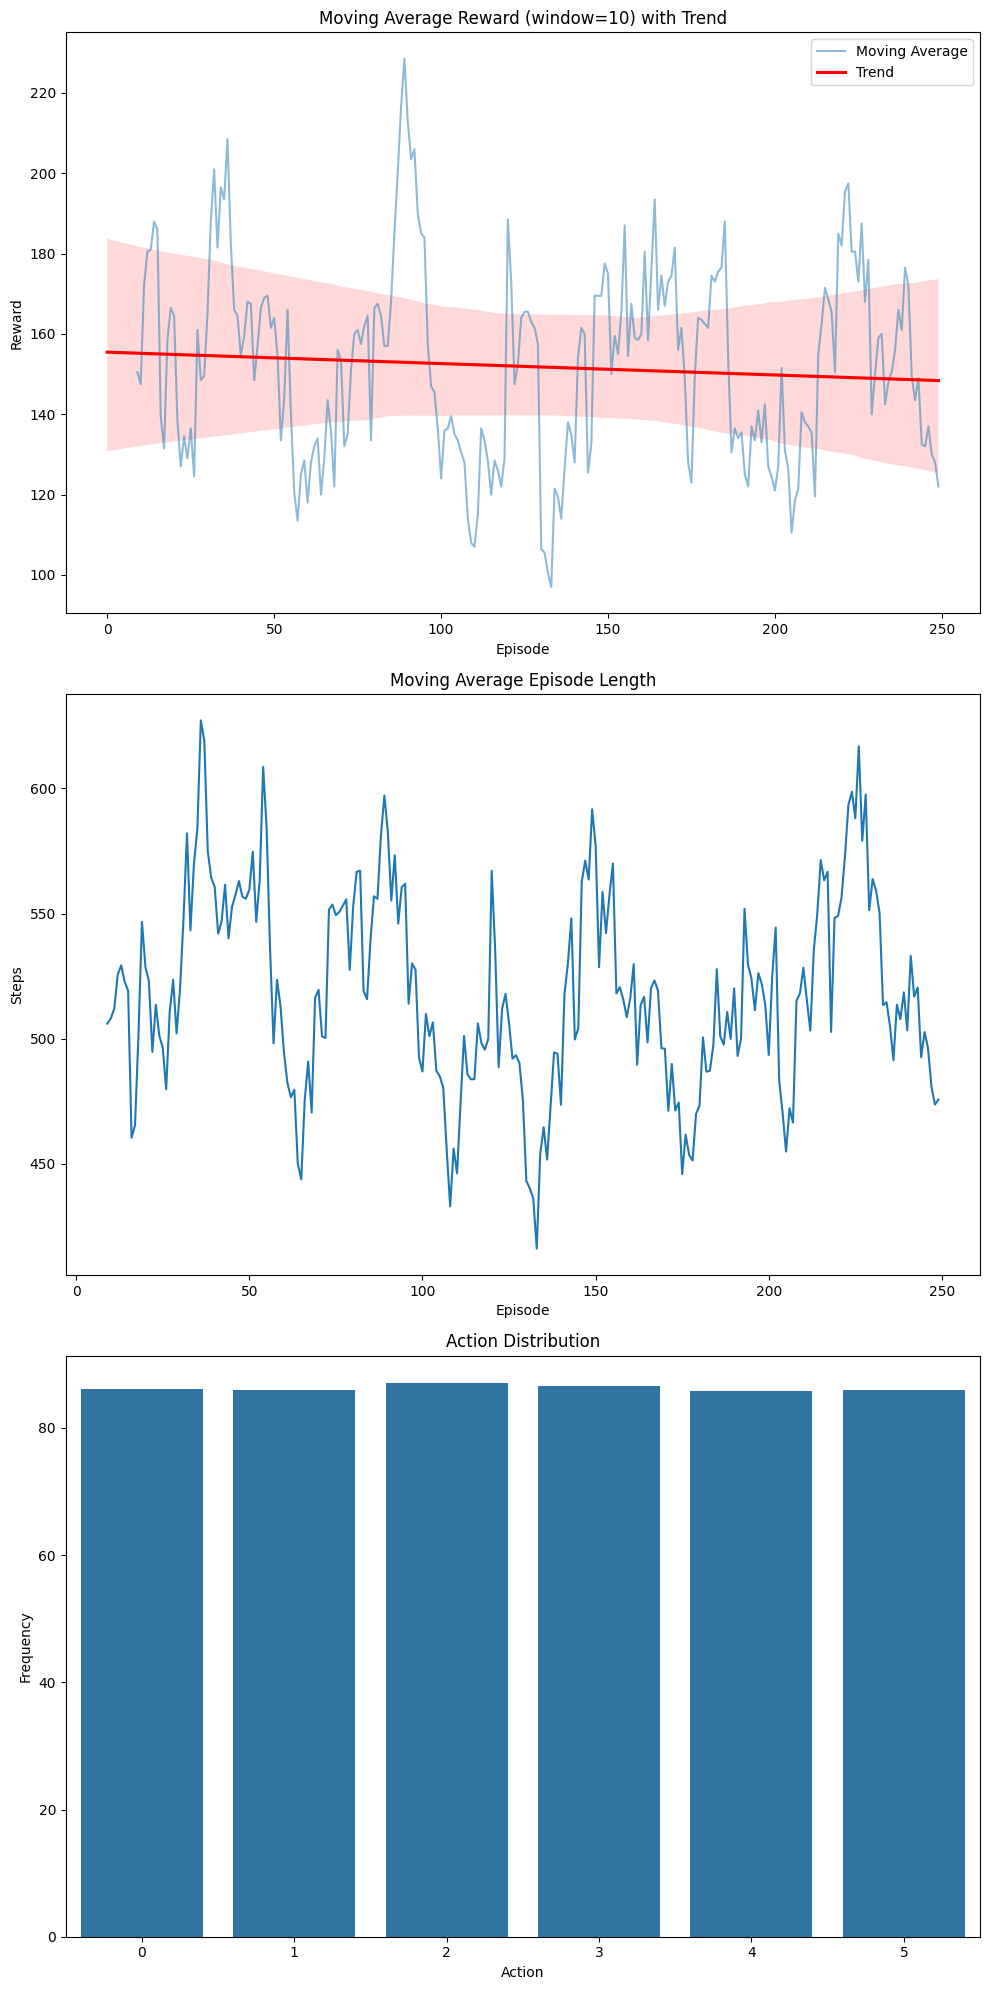


Baseline Metrics Summary:
           reward       length  mean_q  epsilon
count  250.000000   250.000000   250.0    250.0
mean   151.920000   517.548000     0.0      1.0
std    104.607286   160.946147     0.0      0.0
min      5.000000   269.000000     0.0      1.0
25%     80.000000   396.250000     0.0      1.0
50%    130.000000   495.000000     0.0      1.0
75%    203.750000   604.750000     0.0      1.0
max    640.000000  1136.000000     0.0      1.0


In [2]:
class MetricTracker:
    def __init__(self):
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_q_values = []
        self.episode_epsilons = []
        self.action_distributions = []
        
    def update_episode(self, reward, length, q_values, epsilon, actions):
        self.episode_rewards.append(reward)
        self.episode_lengths.append(length)
        self.episode_q_values.append(np.mean(q_values))
        self.episode_epsilons.append(epsilon)
        self.action_distributions.append(np.bincount(actions, minlength=env.action_space.n))
        
    def get_metrics_df(self):
        return pd.DataFrame({
            'reward': self.episode_rewards,
            'length': self.episode_lengths,
            'mean_q': self.episode_q_values,
            'epsilon': self.episode_epsilons
        })

def evaluate_random_agent(num_episodes=100):
    tracker = MetricTracker()
    
    for episode in tqdm(range(num_episodes), desc="Evaluating Random Agent"):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        actions = []
        
        while True:
            action = env.action_space.sample()
            actions.append(action)
            
            next_state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            episode_length += 1
            
            if terminated or truncated:
                break
                
        tracker.update_episode(
            reward=episode_reward,
            length=episode_length,
            q_values=[0],
            epsilon=1.0,
            actions=actions
        )
    
    return tracker

# Run baseline evaluation
baseline_tracker = evaluate_random_agent(num_episodes=250)

# Plot baseline metrics
metrics_df = baseline_tracker.get_metrics_df()
    
fig, axes = plt.subplots(3, 1, figsize=(10, 20))

# Rewards with trend line
sns.lineplot(data=metrics_df['reward'].rolling(10).mean(), ax=axes[0], alpha=0.5, label='Moving Average')
sns.regplot(x=metrics_df.index, y=metrics_df['reward'], ax=axes[0], scatter=False, color='red', label='Trend')
axes[0].set_title('Moving Average Reward (window=10) with Trend')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Reward')
axes[0].legend()

# Episode Lengths
sns.lineplot(data=metrics_df['length'].rolling(10).mean(), ax=axes[1])
axes[1].set_title('Moving Average Episode Length')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Steps')

# Action Distribution
action_dist = np.mean(baseline_tracker.action_distributions, axis=0)
sns.barplot(x=range(len(action_dist)), y=action_dist, ax=axes[2])
axes[2].set_title('Action Distribution')
axes[2].set_xlabel('Action')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nBaseline Metrics Summary:")
print(metrics_df.describe())

## DQN Agent

In [5]:
def preprocess_state(state):
    """Convert state to grayscale and resize"""
    import cv2
    gray = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    return np.expand_dims(resized, axis=0) / 255.0

def train_agent(agent, env, num_episodes, eval_frequency=100):
    """
    Generic training function that works with any agent implementing:
    - select_action(state)
    - store_transition(state, action, reward, next_state, done)
    - optimize_model()
    """
    tracker = MetricTracker()
    best_mean_reward = float('-inf')
    
    for episode in tqdm(range(num_episodes), desc="Training"):
        state, _ = env.reset()
        state = preprocess_state(state)
        episode_reward = 0
        episode_length = 0
        episode_loss = 0
        actions_taken = []
        episode_q_vals = []
        
        while True:
            action, q_values = agent.select_action(state)
            actions_taken.append(action)
            episode_q_vals.append(np.max(q_values))
            
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state = preprocess_state(next_state)
            
            # Store transition and optimize
            agent.store_transition(state, action, reward, next_state, terminated)
            loss = agent.optimize_model()
            if loss is not None:
                episode_loss += loss
            
            state = next_state
            episode_reward += reward
            episode_length += 1
            
            if terminated or truncated:
                break
        
        # Update metrics
        tracker.update_episode(
            reward=episode_reward,
            length=episode_length,
            q_values=episode_q_vals,
            epsilon=agent.epsilon,
            actions=actions_taken
        )
        
        # Decay epsilon
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        # Update target network
        agent.steps_done += episode_length
        if agent.steps_done % agent.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        # Evaluate periodically
        if (episode + 1) % eval_frequency == 0:
            eval_metrics = evaluate_agent(agent, env, num_episodes=10)
            mean_reward = np.mean(eval_metrics.episode_rewards)
            print(f"\nEpisode {episode+1} | Mean Evaluation Reward: {mean_reward:.2f} | Epsilon: {agent.epsilon:.3f}")
    
    return tracker

def evaluate_agent(agent, env, num_episodes=100, render=False):
    """
    Generic evaluation function that works with any agent implementing:
    - select_action(state)
    """
    tracker = MetricTracker()
    
    for episode in tqdm(range(num_episodes), desc="Evaluating"):
        state, _ = env.reset()
        state = preprocess_state(state)
        episode_reward = 0
        episode_length = 0
        actions_taken = []
        episode_q_vals = []
        
        while True:
            if render:
                env.render()
            
            action, q_values = agent.select_action(state)
            actions_taken.append(action)
            episode_q_vals.append(np.max(q_values))
            
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state = preprocess_state(next_state)
            
            state = next_state
            episode_reward += reward
            episode_length += 1
            
            if terminated or truncated:
                break
        
        tracker.update_episode(
            reward=episode_reward,
            length=episode_length,
            q_values=episode_q_vals,
            epsilon=agent.epsilon if hasattr(agent, 'epsilon') else 0.0,
            actions=actions_taken
        )
    
    return tracker

def plot_training_metrics(tracker, title="Training Metrics"):
    """
    Plot metrics from a training or evaluation run
    """
    metrics_df = tracker.get_metrics_df()
    
    fig, axes = plt.subplots(5, 1, figsize=(10, 20))
    fig.suptitle(title)
    
    # Rewards with trend line
    sns.lineplot(data=metrics_df['reward'].rolling(10).mean(), ax=axes[0], alpha=0.5, label='Moving Average')
    sns.regplot(x=metrics_df.index, y=metrics_df['reward'], ax=axes[0], scatter=False, color='red', label='Trend')
    axes[0].set_title('Moving Average Reward (window=10) with Trend')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward')
    axes[0].legend()
    
    # Episode Lengths
    sns.lineplot(data=metrics_df['length'].rolling(10).mean(), ax=axes[1])
    axes[1].set_title('Moving Average Episode Length')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Steps')
    
    # Q-Values
    sns.lineplot(data=metrics_df['mean_q'].rolling(10).mean(), ax=axes[2])
    axes[2].set_title('Moving Average Q-Value')
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Mean Q-Value')
    
    # Epsilon
    sns.lineplot(data=metrics_df['epsilon'], ax=axes[3])
    axes[3].set_title('Epsilon Decay')
    axes[3].set_xlabel('Episode')
    axes[3].set_ylabel('Epsilon')
    
    # Action Distribution
    action_dist = np.mean(tracker.action_distributions, axis=0)
    sns.barplot(x=range(len(action_dist)), y=action_dist, ax=axes[4])
    axes[4].set_title('Action Distribution')
    axes[4].set_xlabel('Action')
    axes[4].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nMetrics Summary:")
    print(metrics_df.describe())


In [6]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

class DQNAgent:
    def __init__(self, state_shape, n_actions, device="cuda" if torch.cuda.is_available() else "cpu", lr=0.0001, memory_size=100000, batch_size=32, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, target_update=1000):
        self.device = device
        self.state_shape = state_shape
        self.n_actions = n_actions
        
        self.policy_net = DQN(state_shape, n_actions).to(device)
        self.target_net = DQN(state_shape, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = deque(maxlen=memory_size)
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update
        self.steps_done = 0
        
    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item(), q_values.cpu().numpy()
        else:
            return random.randrange(self.n_actions), np.zeros(self.n_actions)
        
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append(Transition(state, action, reward, next_state, done))
        
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        transitions = random.sample(self.memory, self.batch_size)
        batch = Transition(*zip(*transitions))
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=self.device, dtype=torch.bool)
        
        state_batch = torch.FloatTensor(np.array(batch.state)).to(self.device)
        action_batch = torch.LongTensor(batch.action).to(self.device)
        reward_batch = torch.FloatTensor(batch.reward).to(self.device)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        if any(non_final_mask):
            non_final_next_states = torch.FloatTensor(np.array([s for s in batch.next_state if s is not None])).to(self.device)
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
            
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        
        loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
        return loss.item()

Training:  10%|█         | 100/1000 [03:15<42:50,  2.86s/it]


Episode 100 | Mean Evaluation Reward: 95.50 | Epsilon: 0.606


Training:  20%|██        | 200/1000 [06:46<54:42,  4.10s/it]


Episode 200 | Mean Evaluation Reward: 161.50 | Epsilon: 0.367


Training:  30%|███       | 300/1000 [10:38<41:53,  3.59s/it]


Episode 300 | Mean Evaluation Reward: 208.50 | Epsilon: 0.222


Training:  40%|████      | 400/1000 [15:05<40:59,  4.10s/it]


Episode 400 | Mean Evaluation Reward: 200.00 | Epsilon: 0.135


Training:  50%|█████     | 500/1000 [19:24<32:47,  3.94s/it]


Episode 500 | Mean Evaluation Reward: 157.50 | Epsilon: 0.100


Training:  60%|██████    | 600/1000 [23:36<32:18,  4.85s/it]


Episode 600 | Mean Evaluation Reward: 229.50 | Epsilon: 0.100


Training:  70%|███████   | 700/1000 [28:02<23:12,  4.64s/it]


Episode 700 | Mean Evaluation Reward: 153.00 | Epsilon: 0.100


Training:  80%|████████  | 800/1000 [32:41<14:28,  4.34s/it]


Episode 800 | Mean Evaluation Reward: 249.00 | Epsilon: 0.100


Training:  90%|█████████ | 900/1000 [37:03<08:01,  4.82s/it]


Episode 900 | Mean Evaluation Reward: 264.00 | Epsilon: 0.100


Training: 100%|██████████| 1000/1000 [41:39<00:00,  2.50s/it]



Episode 1000 | Mean Evaluation Reward: 148.00 | Epsilon: 0.100


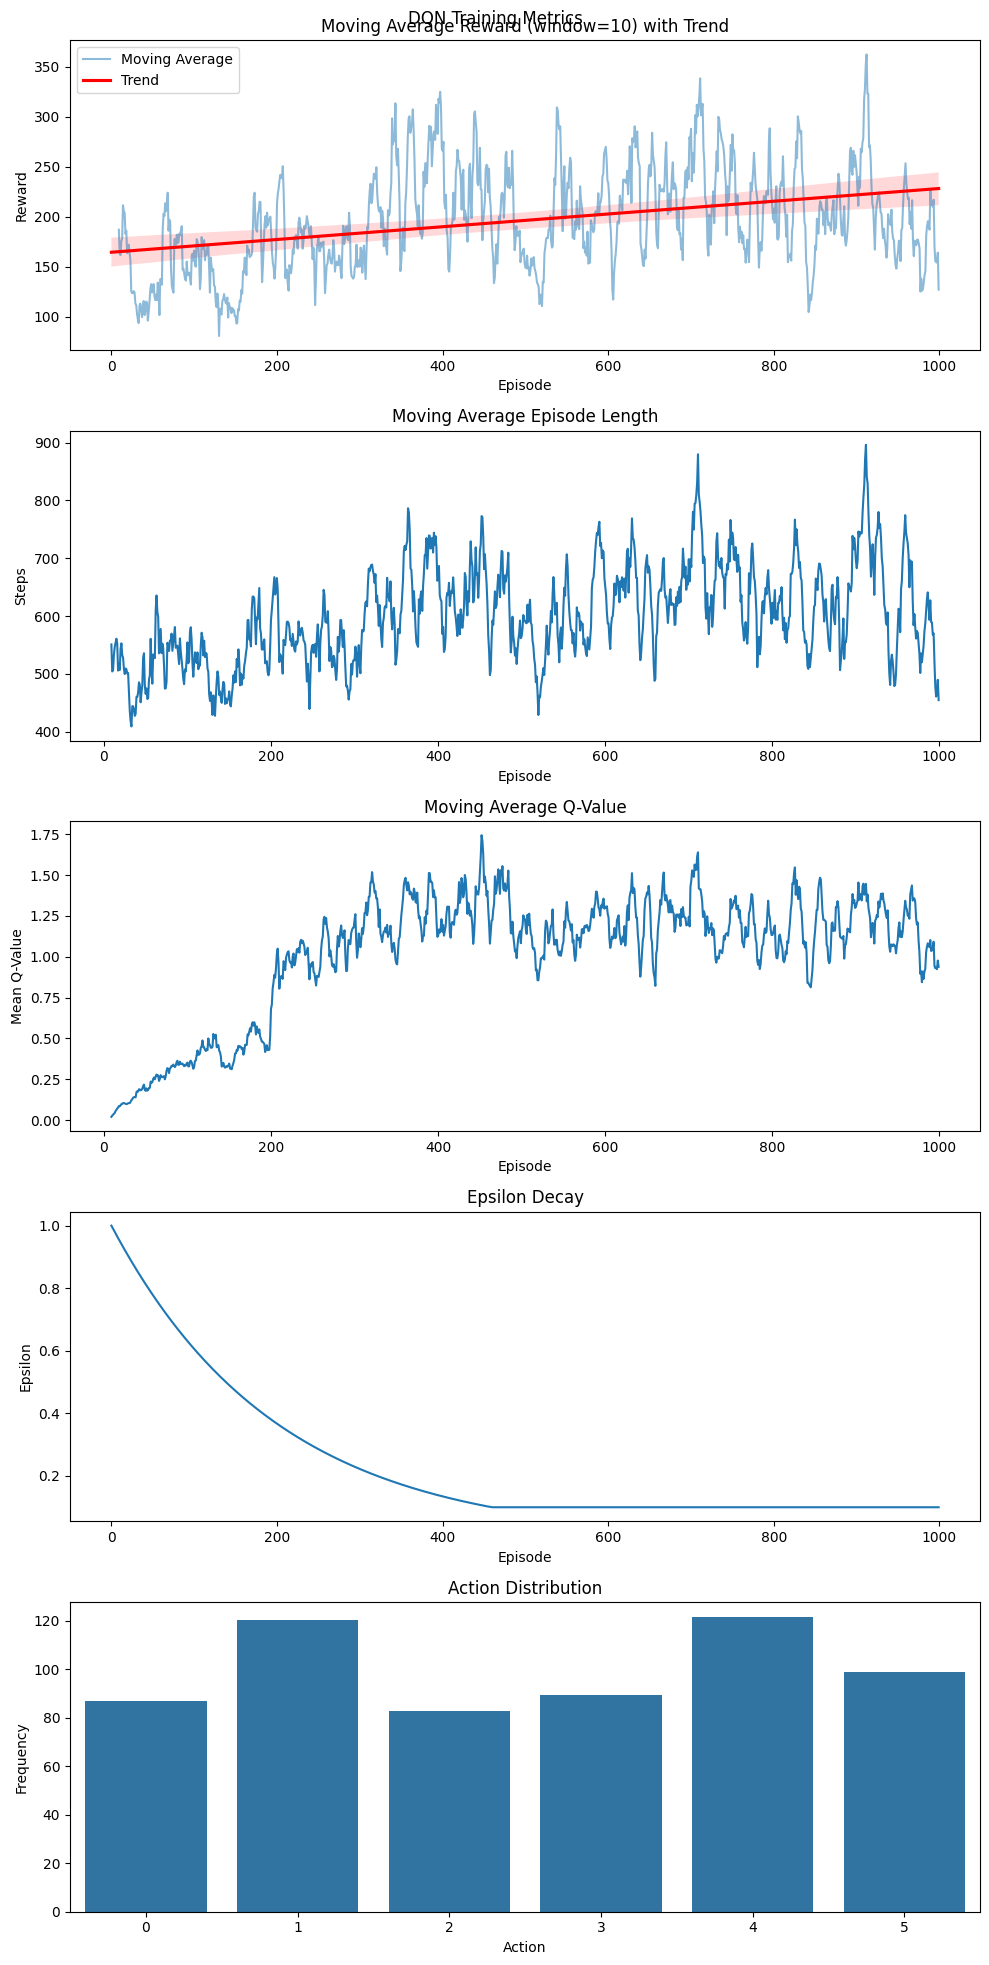


Metrics Summary:
            reward       length       mean_q      epsilon
count  1000.000000  1000.000000  1000.000000  1000.000000
mean    196.300000   600.460000     1.019088     0.234064
std     136.205036   207.118213     0.539110     0.223425
min       5.000000   238.000000     0.000000     0.100000
25%     100.000000   461.000000     0.642151     0.100000
50%     160.000000   568.000000     0.972088     0.100000
75%     255.000000   737.000000     1.364625     0.285967
max     810.000000  1322.000000     3.086232     1.000000


Evaluating: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


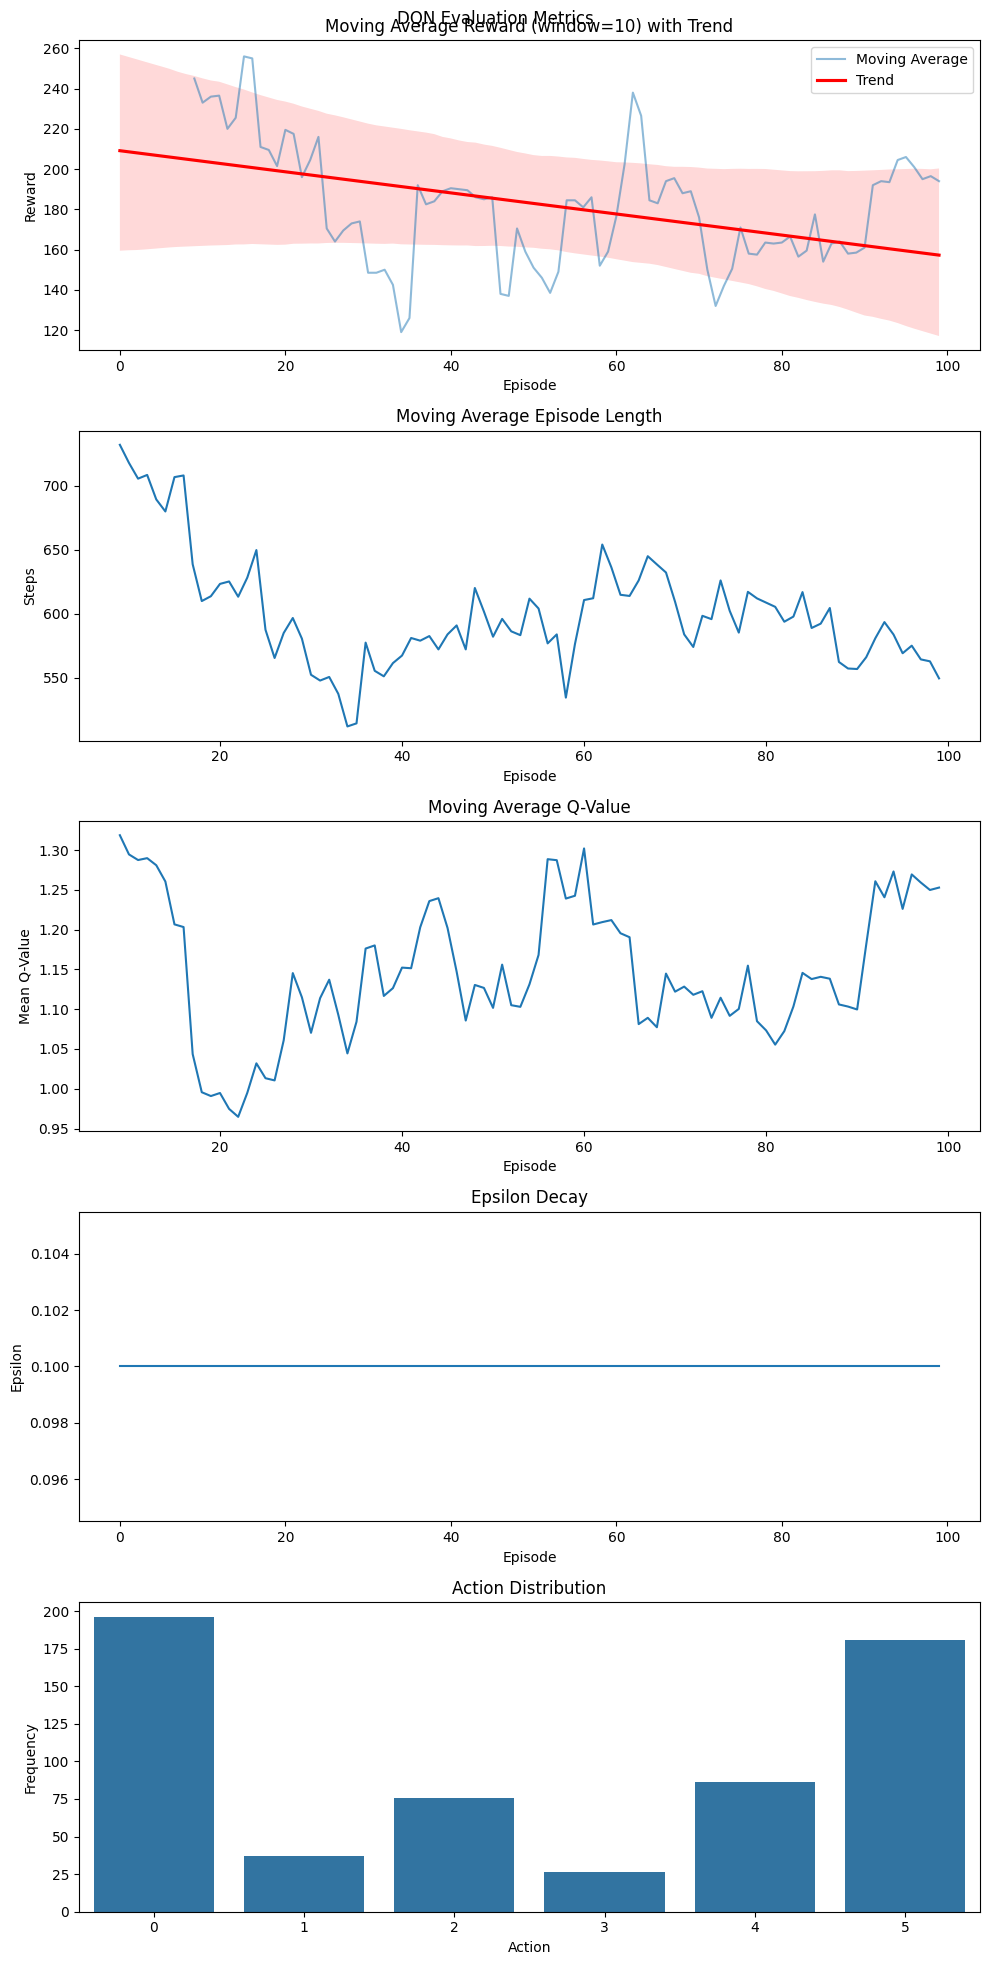


Metrics Summary:
           reward       length      mean_q       epsilon
count  100.000000   100.000000  100.000000  1.000000e+02
mean   183.200000   601.680000    1.150627  1.000000e-01
std    121.784957   170.687551    0.328426  2.789540e-17
min     35.000000   288.000000    0.690240  1.000000e-01
25%    110.000000   500.750000    0.880585  1.000000e-01
50%    137.500000   567.500000    1.076357  1.000000e-01
75%    201.250000   703.250000    1.323120  1.000000e-01
max    715.000000  1193.000000    2.556205  1.000000e-01


In [7]:
# Create environment and agent
env = gym.make("ALE/SpaceInvaders-v5")
# Since we are pre-processing the state, we need to get the shape of the pre-processed state
state_shape = preprocess_state(env.reset()[0]).shape
n_actions = env.action_space.n

# Initialize agent
dqn_agent = DQNAgent(state_shape, n_actions)

# Train
training_tracker = train_agent(dqn_agent, env, num_episodes=1000, eval_frequency=100)

# Plot training metrics
plot_training_metrics(training_tracker, "DQN Training Metrics")

## Improvements

### Environmental changes
- Frame stacking: Using multiple frames as input to the agent to give it a sense of motion.
- Frame skipping: Skipping frames to speed up training and reduce flickering.
- Reward clipping: Clipping the rewards to a range of [-1, 1] to stabilize the learning process.

### Replay buffer warmup
By letting the agent collect many experiences before starting the training process, this prevents the Q-network from immediately overfitting to the few experiences it has seen.

### Algorithmic improvements
- Double DQN: Using two Q-networks to decouple the action selection from the value estimation. This helps to reduce overestimation bias.
- Dueling DQN: Decoupling the value estimation from the action selection.
- Dueling Double DQN: Combining of both Double DQN and Dueling DQN.

In [8]:
# Reward clipper
class RewardClipper(gym.RewardWrapper):
    def __init__(self, env):
        """
            Wraps the environment to clip rewards to +1, 0, or -1 by taking the sign of the reward.
        """
        super(RewardClipper, self).__init__(env)
        
    def reward(self, reward):
        return np.sign(reward)
    
def make_env(env_name="ALE/SpaceInvaders-v5"):
    env = gym.make(env_name, frameskip=1)
    env = AtariPreprocessing(
        env,
        frame_skip=4
    )

    env = FrameStackObservation(env, stack_size=4)
    env = RewardClipper(env)

    return env

# Now with this new environment, we no longer need to preprocess the state so below are the updated train and evaluate functions
def train_agent(agent, env, num_episodes, eval_frequency=100):
    """
    Generic training function that works with any agent implementing:
    - select_action(state)
    - store_transition(state, action, reward, next_state, done)
    - optimize_model()
    """
    tracker = MetricTracker()
    best_mean_reward = float('-inf')
    episode_q_values = []
    training_metrics = []
    
    for episode in tqdm(range(num_episodes), desc="Training"):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        episode_loss = 0
        actions_taken = []
        episode_q_vals = []
        
        while True:
            action, q_values = agent.select_action(state)
            actions_taken.append(action)
            episode_q_vals.append(np.max(q_values))
            
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Store transition and optimize
            agent.store_transition(state, action, reward, next_state, terminated)
            loss = agent.optimize_model()
            if loss is not None:
                episode_loss += loss
            
            state = next_state
            episode_reward += reward
            episode_length += 1
            
            if terminated or truncated:
                break
        
        # Update metrics
        tracker.update_episode(
            reward=episode_reward,
            length=episode_length,
            q_values=episode_q_vals,
            epsilon=agent.epsilon,
            actions=actions_taken
        )
        
        # Decay epsilon
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        # Update target network
        agent.steps_done += episode_length
        if agent.steps_done % agent.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        # Evaluate periodically
        if (episode + 1) % eval_frequency == 0:
            eval_metrics = evaluate_agent(agent, env, num_episodes=10)
            mean_reward = np.mean(eval_metrics.episode_rewards)
            print(f"\nEpisode {episode+1} | Mean Evaluation Reward: {mean_reward:.2f} | Epsilon: {agent.epsilon:.3f}")
    
    return tracker

def evaluate_agent(agent, env, num_episodes=100, render=False):
    """
    Generic evaluation function that works with any agent implementing:
    - select_action(state)
    """
    tracker = MetricTracker()
    
    for episode in tqdm(range(num_episodes), desc="Evaluating"):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        actions_taken = []
        episode_q_vals = []
        
        while True:
            if render:
                env.render()
            
            action, q_values = agent.select_action(state)
            actions_taken.append(action)
            episode_q_vals.append(np.max(q_values))
            
            next_state, reward, terminated, truncated, info = env.step(action)
            
            state = next_state
            episode_reward += reward
            episode_length += 1
            
            if terminated or truncated:
                break
        
        tracker.update_episode(
            reward=episode_reward,
            length=episode_length,
            q_values=episode_q_vals,
            epsilon=agent.epsilon if hasattr(agent, 'epsilon') else 0.0,
            actions=actions_taken
        )
    
    return tracker

Training:  10%|█         | 100/1000 [04:05<54:15,  3.62s/it]


Episode 100 | Mean Evaluation Reward: 8.70 | Epsilon: 0.606


Training:  20%|██        | 200/1000 [08:29<48:22,  3.63s/it]


Episode 200 | Mean Evaluation Reward: 7.30 | Epsilon: 0.367


Training:  30%|███       | 300/1000 [12:45<44:47,  3.84s/it]


Episode 300 | Mean Evaluation Reward: 11.90 | Epsilon: 0.222


Training:  40%|████      | 400/1000 [17:09<45:19,  4.53s/it]


Episode 400 | Mean Evaluation Reward: 10.80 | Epsilon: 0.135


Training:  50%|█████     | 500/1000 [21:20<33:21,  4.00s/it]


Episode 500 | Mean Evaluation Reward: 11.50 | Epsilon: 0.100


Training:  60%|██████    | 600/1000 [25:46<30:27,  4.57s/it]


Episode 600 | Mean Evaluation Reward: 10.80 | Epsilon: 0.100


Training:  70%|███████   | 700/1000 [30:17<22:13,  4.45s/it]


Episode 700 | Mean Evaluation Reward: 10.60 | Epsilon: 0.100


Training:  80%|████████  | 800/1000 [34:36<15:16,  4.58s/it]


Episode 800 | Mean Evaluation Reward: 12.30 | Epsilon: 0.100


Training:  90%|█████████ | 900/1000 [38:51<08:23,  5.03s/it]


Episode 900 | Mean Evaluation Reward: 10.70 | Epsilon: 0.100


Training: 100%|██████████| 1000/1000 [42:58<00:00,  2.58s/it]



Episode 1000 | Mean Evaluation Reward: 7.60 | Epsilon: 0.100


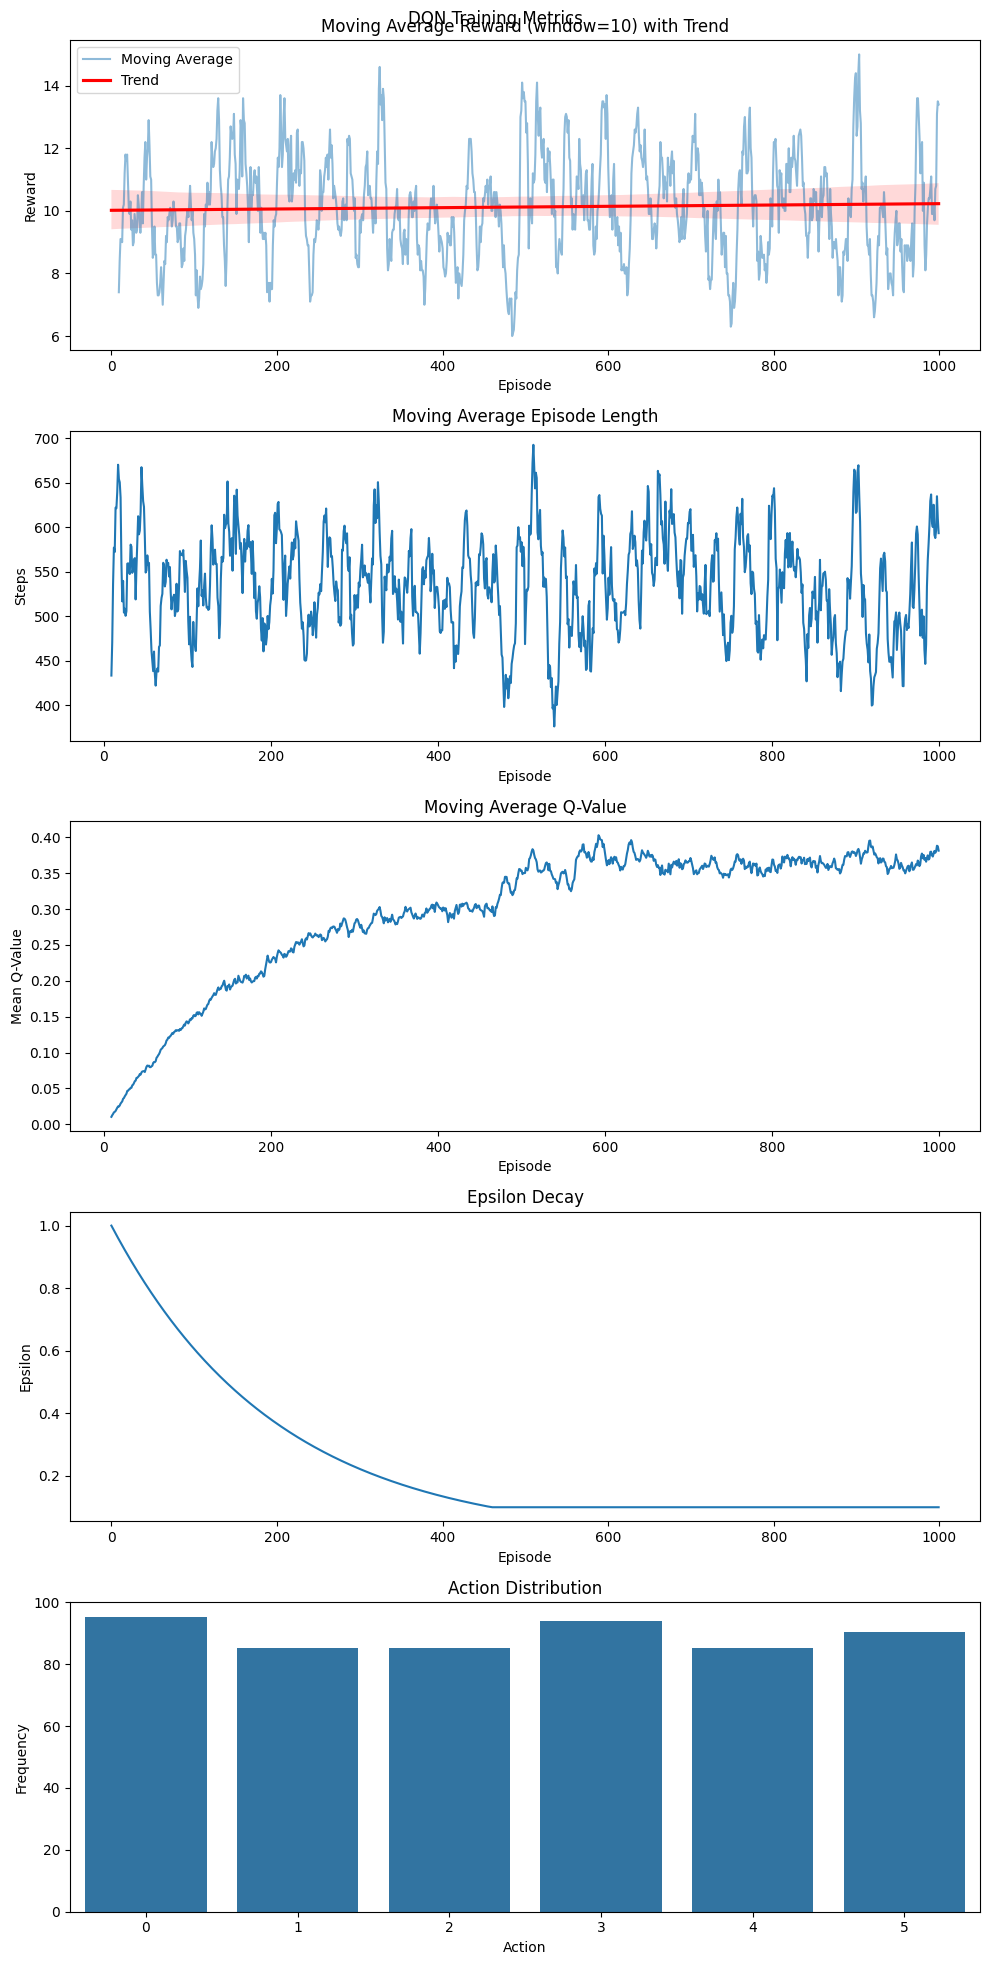


Metrics Summary:
            reward      length       mean_q      epsilon
count  1000.000000  1000.00000  1000.000000  1000.000000
mean     10.124000   535.22200     0.295691     0.234064
std       5.239664   177.66337     0.097333     0.223425
min       1.000000   248.00000     0.000000     0.100000
25%       6.000000   409.00000     0.250455     0.100000
50%       9.000000   504.00000     0.321283     0.100000
75%      13.000000   625.00000     0.366712     0.285967
max      33.000000  1328.00000     0.458706     1.000000


In [9]:
env = make_env()
state, _ = env.reset()
state_shape = state.shape

# Initialize agent
dqn_agent = DQNAgent(state_shape, env.action_space.n)

# Train
training_tracker = train_agent(dqn_agent, env, num_episodes=1000, eval_frequency=100)

# Plot training metrics
plot_training_metrics(training_tracker, "DQN Training Metrics")

In [10]:
# New training loop to let the replay buffer warm up
def train_agent_with_warmup(agent, env, num_episodes, eval_frequency=100, warmup_steps=5000, max_steps_per_episode=2000):
    """
    Train function that includes a replay buffer warm-up phase.
    """
    print(f"Collecting {warmup_steps} transitions with random actions for warm-up...")
    state, _ = env.reset()
    for _ in range(warmup_steps):
        # Take a random action
        action = env.action_space.sample()
        
        next_state, reward, terminated, truncated, info = env.step(action)
        
        # Store transition in the replay buffer
        agent.store_transition(state, action, reward, next_state, terminated)
        
        if terminated or truncated:
            # Reset environment
            state, _ = env.reset()
        else:
            state = next_state

    tracker = MetricTracker()
    best_mean_reward = float('-inf')
    
    for episode in tqdm(range(num_episodes), desc="Training"):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        actions_taken = []  
        episode_q_vals = []
        
        step_count = 0
        while True:
            action, q_values = agent.select_action(state)
            actions_taken.append(action)
            episode_q_vals.append(np.max(q_values))
            
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Store transition in memory
            agent.store_transition(state, action, reward, next_state, terminated)

            loss = agent.optimize_model()
            
            state = next_state
            episode_reward += reward
            episode_length += 1
            step_count += 1
            
            if terminated or truncated or step_count >= max_steps_per_episode:
                break
        
        # Decay epsilon, update metrics, etc.
        tracker.update_episode(
            reward=episode_reward,
            length=episode_length,
            q_values=episode_q_vals,
            epsilon=agent.epsilon,
            actions=actions_taken
        )
        
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        agent.steps_done += episode_length
        
        # Target network update if needed
        if agent.steps_done % agent.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        
        # Periodic evaluation
        if (episode + 1) % eval_frequency == 0:
            eval_metrics = evaluate_agent(agent, env, num_episodes=10)
            mean_reward = np.mean(eval_metrics.episode_rewards)
            print(f"\nEpisode {episode+1} | Mean Eval Reward: {mean_reward:.2f} | Epsilon: {agent.epsilon:.3f}")
    
    return tracker

Training:  10%|█         | 100/1000 [03:51<51:30,  3.43s/it]


Episode 100 | Mean Eval Reward: 8.90 | Epsilon: 0.606


Training:  20%|██        | 200/1000 [07:53<1:01:43,  4.63s/it]


Episode 200 | Mean Eval Reward: 9.70 | Epsilon: 0.367


Training:  30%|███       | 300/1000 [11:57<45:19,  3.89s/it]


Episode 300 | Mean Eval Reward: 10.00 | Epsilon: 0.222


Training:  40%|████      | 400/1000 [15:55<41:15,  4.13s/it]


Episode 400 | Mean Eval Reward: 14.60 | Epsilon: 0.135


Training:  50%|█████     | 500/1000 [20:11<36:19,  4.36s/it]


Episode 500 | Mean Eval Reward: 13.40 | Epsilon: 0.100


Training:  60%|██████    | 600/1000 [24:34<26:45,  4.01s/it]


Episode 600 | Mean Eval Reward: 11.40 | Epsilon: 0.100


Training:  70%|███████   | 700/1000 [28:47<23:12,  4.64s/it]


Episode 700 | Mean Eval Reward: 11.70 | Epsilon: 0.100


Training:  80%|████████  | 800/1000 [32:46<15:47,  4.74s/it]


Episode 800 | Mean Eval Reward: 17.30 | Epsilon: 0.100


Training:  90%|█████████ | 900/1000 [36:41<05:49,  3.49s/it]


Episode 900 | Mean Eval Reward: 8.80 | Epsilon: 0.100


Training: 100%|██████████| 1000/1000 [40:43<00:00,  2.44s/it]



Episode 1000 | Mean Eval Reward: 13.10 | Epsilon: 0.100


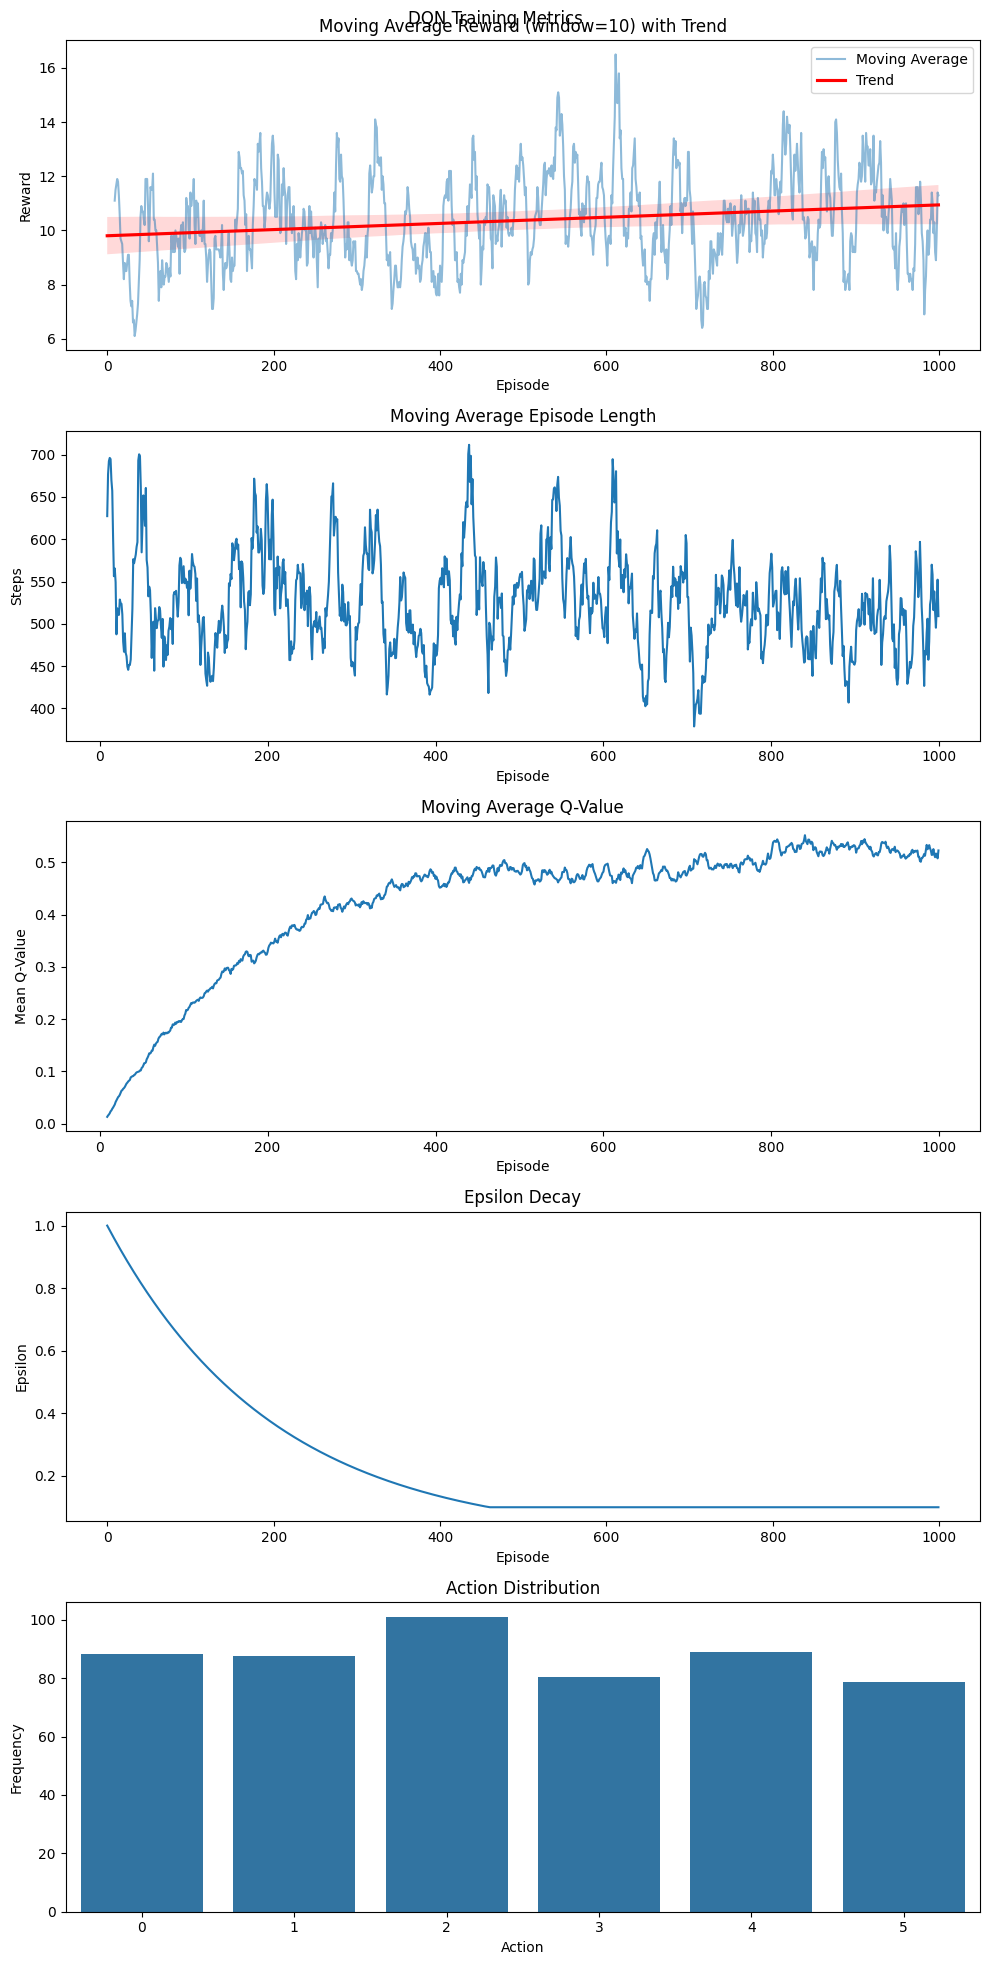


Metrics Summary:
            reward       length       mean_q      epsilon
count  1000.000000  1000.000000  1000.000000  1000.000000
mean     10.373000   525.289000     0.423545     0.234064
std       5.521264   186.842848     0.129110     0.223425
min       1.000000   222.000000     0.000000     0.100000
25%       6.000000   390.000000     0.392994     0.100000
50%       9.000000   486.000000     0.467843     0.100000
75%      13.000000   626.000000     0.505403     0.285967
max      35.000000  1531.000000     0.637004     1.000000


In [11]:
# Initialize agent
env = make_env()
state, _ = env.reset()
state_shape = state.shape

dqn_agent = DQNAgent(state_shape, env.action_space.n)

# Train
training_tracker = train_agent_with_warmup(dqn_agent, env, num_episodes=1000, eval_frequency=100, warmup_steps=5000)

# Plot training metrics
plot_training_metrics(training_tracker, "DQN Training Metrics")

## Double DQN

In [12]:
class DoubleDQNAgent(DQNAgent):
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        transitions = random.sample(self.memory, self.batch_size)
        batch = Transition(*zip(*transitions))
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), 
                                                device=self.device, 
                                                dtype=torch.bool)
        
        state_batch = torch.FloatTensor(np.array(batch.state)).to(self.device)
        action_batch = torch.LongTensor(batch.action).to(self.device)
        reward_batch = torch.FloatTensor(batch.reward).to(self.device)

        # Calculate Q-values for the actions taken
        state_action_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

        # Compute the next state values for all next states
        next_state_values = torch.zeros(self.batch_size, device=self.device)

        if any(non_final_mask):
            non_final_next_states = torch.FloatTensor(
                np.array([s for s in batch.next_state if s is not None])
            ).to(self.device)

            # Get the best actions from the policy network
            online_best_actions = self.policy_net(non_final_next_states).max(1)[1].unsqueeze(1)

            # Get the value of the actions from the target network
            target_values = self.target_net(non_final_next_states).gather(1, online_best_actions).squeeze(1)
            next_state_values[non_final_mask] = target_values.detach()

        # Compute the expected Q-values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute the loss
        loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return loss.item()

Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]



Episode 100 | Mean Eval Reward: 11.60 | Epsilon: 0.606


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]



Episode 200 | Mean Eval Reward: 7.00 | Epsilon: 0.367


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]



Episode 300 | Mean Eval Reward: 11.80 | Epsilon: 0.222


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]



Episode 400 | Mean Eval Reward: 14.10 | Epsilon: 0.135


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]



Episode 500 | Mean Eval Reward: 9.50 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]



Episode 600 | Mean Eval Reward: 14.70 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]



Episode 700 | Mean Eval Reward: 12.10 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]



Episode 800 | Mean Eval Reward: 12.20 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]



Episode 900 | Mean Eval Reward: 9.10 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]



Episode 1000 | Mean Eval Reward: 7.90 | Epsilon: 0.100


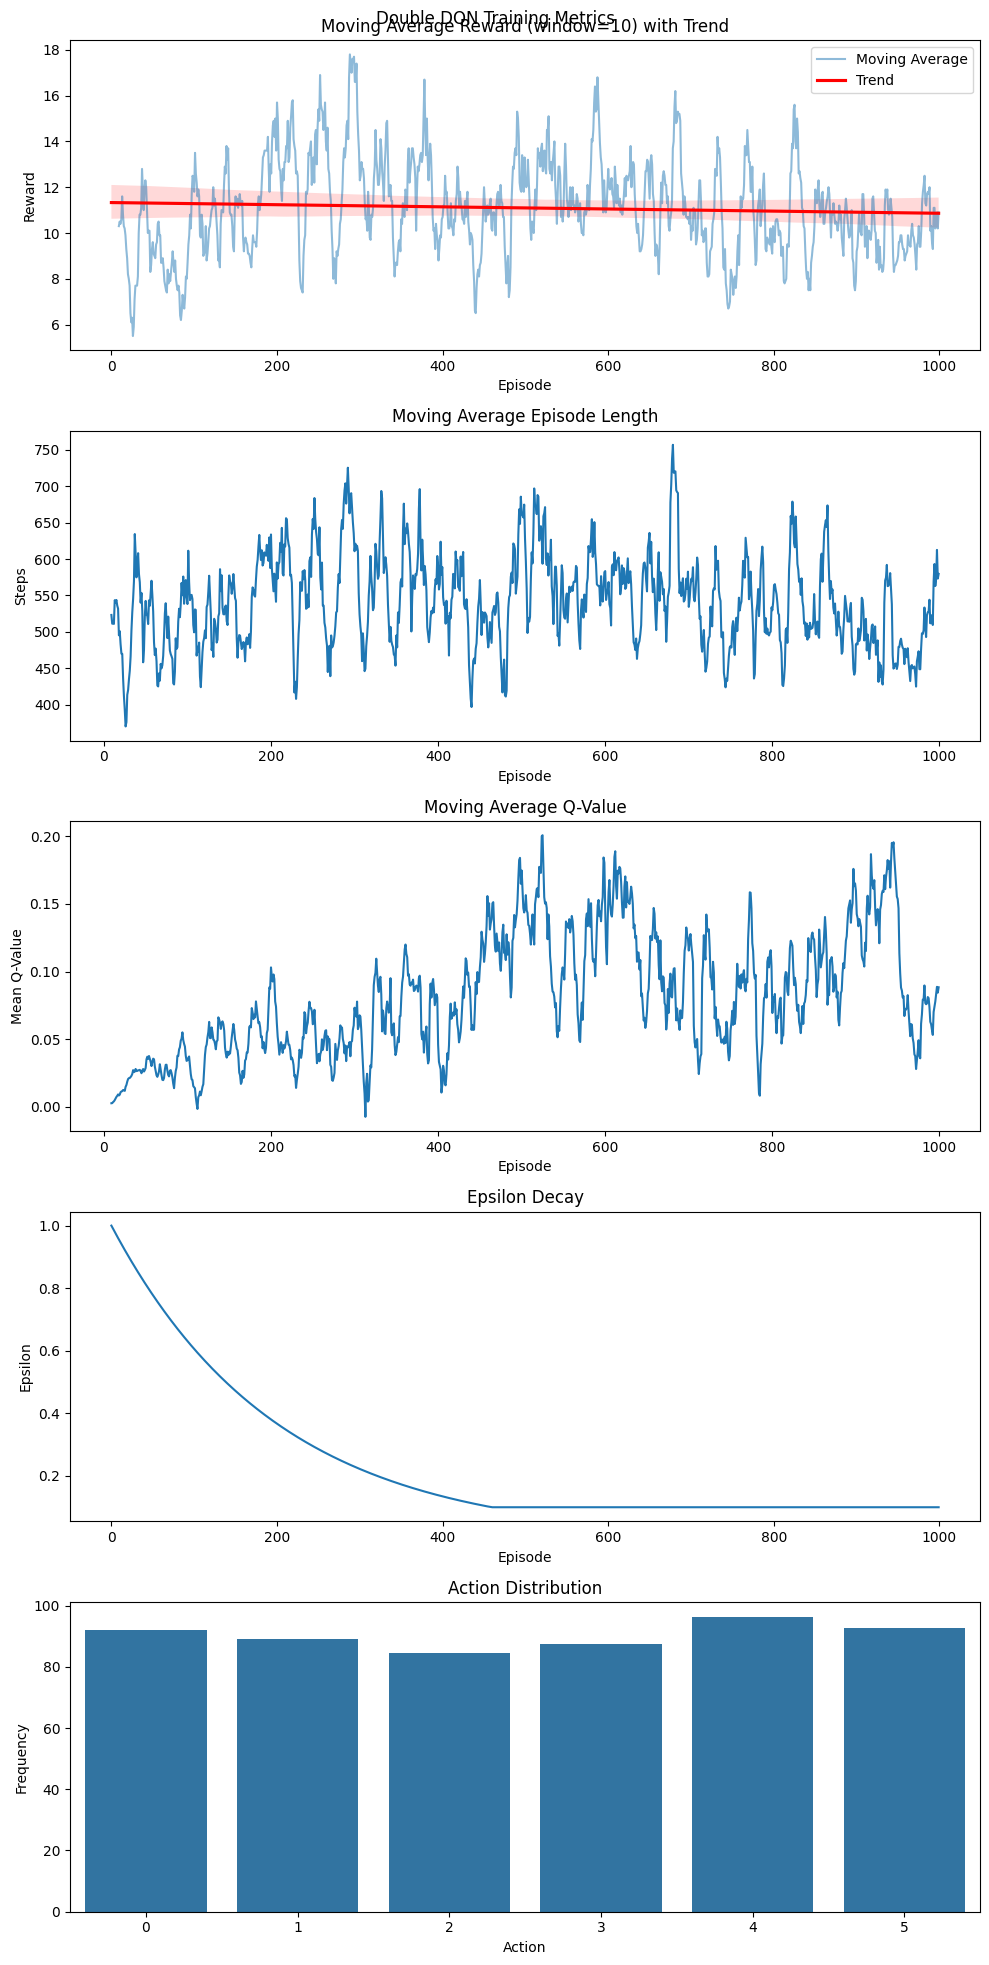


Metrics Summary:
            reward       length       mean_q      epsilon
count  1000.000000  1000.000000  1000.000000  1000.000000
mean     11.096000   542.469000     0.081622     0.234064
std       5.796929   188.574514     0.085770     0.223425
min       1.000000   224.000000    -0.235401     0.100000
25%       7.000000   401.000000     0.023309     0.100000
50%      10.000000   506.000000     0.070034     0.100000
75%      15.000000   658.750000     0.129661     0.285967
max      36.000000  1540.000000     0.497925     1.000000


In [8]:
env = make_env()
state, _ = env.reset()
state_shape = state.shape

doubleAgent = DoubleDQNAgent(state_shape, env.action_space.n)

# Train
training_tracker = train_agent_with_warmup(doubleAgent, env, num_episodes=1000, eval_frequency=100, warmup_steps=10000)

# Plot training metrics
plot_training_metrics(training_tracker, "Double DQN Training Metrics")

## Dueling DQN

In [16]:
class DuelingDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DuelingDQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        # Dueling streams:
        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x)
        conv_out = conv_out.view(conv_out.size(0), -1)

        # Split into value and advantage
        value = self.value_stream(conv_out)
        advantage = self.advantage_stream(conv_out)

        # Combine them into Q-values
        advantage_mean = advantage.mean(dim=1, keepdim=True)
        q_values = value + (advantage - advantage_mean)

        return q_values

class DuelingDQNAgent(DQNAgent):
    def __init__(
        self, 
        state_shape, 
        n_actions, 
        device="cuda" if torch.cuda.is_available() else "cpu",
        lr=0.0001, 
        memory_size=100000, 
        batch_size=32,
        gamma=0.99, 
        epsilon=1.0, 
        epsilon_min=0.1, 
        epsilon_decay=0.995, 
        target_update=1000
    ):
        self.device = device
        self.state_shape = state_shape
        self.n_actions = n_actions
        
        self.policy_net = DuelingDQN(state_shape, n_actions).to(device)
        self.target_net = DuelingDQN(state_shape, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        
        self.memory = deque(maxlen=memory_size)
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update
        self.steps_done = 0
        
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        transitions = random.sample(self.memory, self.batch_size)
        batch = Transition(*zip(*transitions))
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=self.device, dtype=torch.bool)
        
        state_batch = torch.FloatTensor(np.array(batch.state)).to(self.device)
        action_batch = torch.LongTensor(batch.action).to(self.device)
        reward_batch = torch.FloatTensor(batch.reward).to(self.device)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        if any(non_final_mask):
            non_final_next_states = torch.FloatTensor(np.array([s for s in batch.next_state if s is not None])).to(self.device)
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
            
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        
        loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
        return loss.item()

Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]



Episode 100 | Mean Eval Reward: 8.60 | Epsilon: 0.606


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]



Episode 200 | Mean Eval Reward: 10.70 | Epsilon: 0.367


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]



Episode 300 | Mean Eval Reward: 11.40 | Epsilon: 0.222


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]



Episode 400 | Mean Eval Reward: 10.20 | Epsilon: 0.135


Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]



Episode 500 | Mean Eval Reward: 12.40 | Epsilon: 0.100


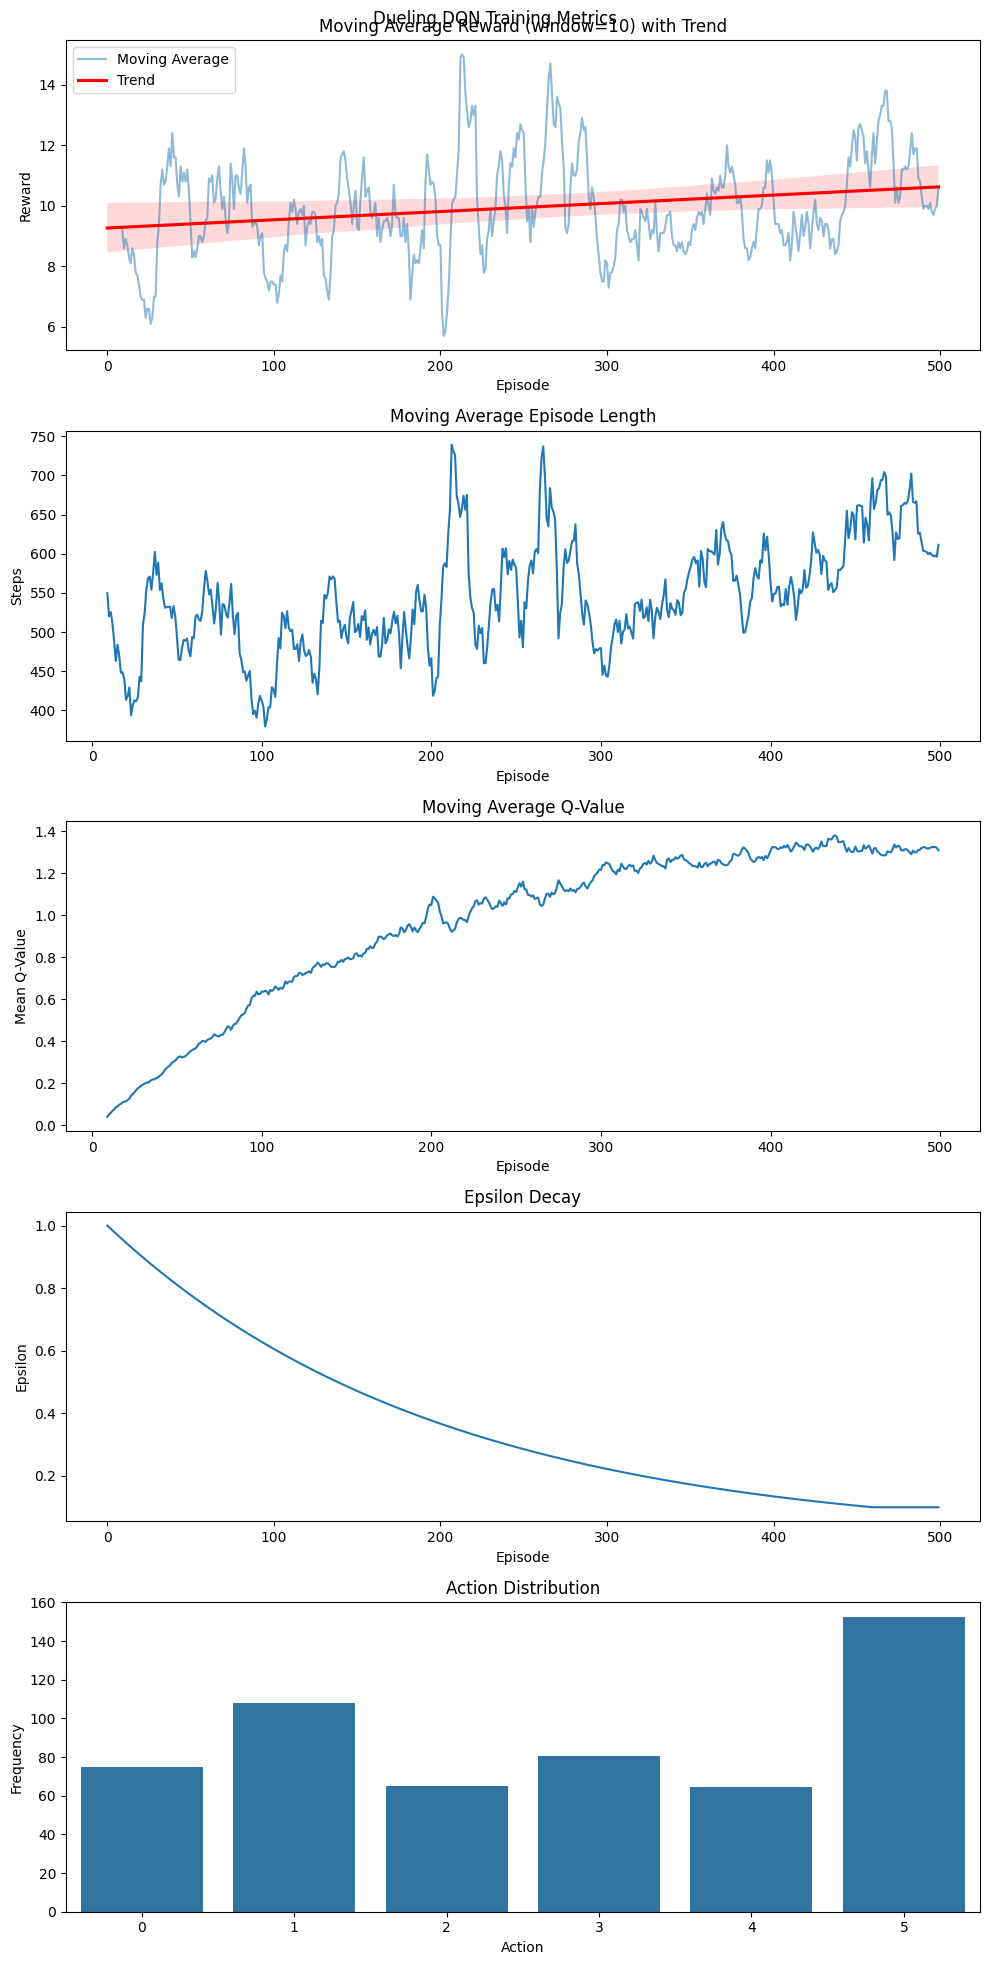


Metrics Summary:
           reward       length      mean_q     epsilon
count  500.000000   500.000000  500.000000  500.000000
mean     9.946000   545.576000    0.960424    0.368127
std      4.525931   169.220493    0.385087    0.252822
min      1.000000   248.000000    0.000000    0.100000
25%      7.000000   434.000000    0.727040    0.153211
50%      9.000000   527.000000    1.086373    0.286325
75%     12.000000   626.000000    1.271000    0.535094
max     37.000000  1386.000000    1.645634    1.000000


In [25]:
env = make_env()
state, _ = env.reset()
state_shape = state.shape

duelingAgent = DuelingDQNAgent(state_shape, env.action_space.n)

# Train
training_tracker = train_agent_with_warmup(duelingAgent, env, num_episodes=500, eval_frequency=100, warmup_steps=10000)

# Plot training metrics
plot_training_metrics(training_tracker, "Dueling DQN Training Metrics")

## Combining Double and Dueling DQN

In [14]:
class DoubleDuelingDQNAgent(DoubleDQNAgent):
    def __init__(self, state_shape, n_actions, **kwargs):
        super().__init__(state_shape, n_actions, **kwargs)

        self.policy_net = DuelingDQN(state_shape, n_actions).to(self.device)
        self.target_net = DuelingDQN(state_shape, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]



Episode 100 | Mean Eval Reward: 10.20 | Epsilon: 0.606


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]



Episode 200 | Mean Eval Reward: 11.80 | Epsilon: 0.367


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]



Episode 300 | Mean Eval Reward: 12.80 | Epsilon: 0.222


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]



Episode 400 | Mean Eval Reward: 14.10 | Epsilon: 0.135


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]



Episode 500 | Mean Eval Reward: 13.20 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]



Episode 600 | Mean Eval Reward: 8.00 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]



Episode 700 | Mean Eval Reward: 7.10 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]



Episode 800 | Mean Eval Reward: 10.10 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]



Episode 900 | Mean Eval Reward: 12.00 | Epsilon: 0.100


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]



Episode 1000 | Mean Eval Reward: 11.40 | Epsilon: 0.100


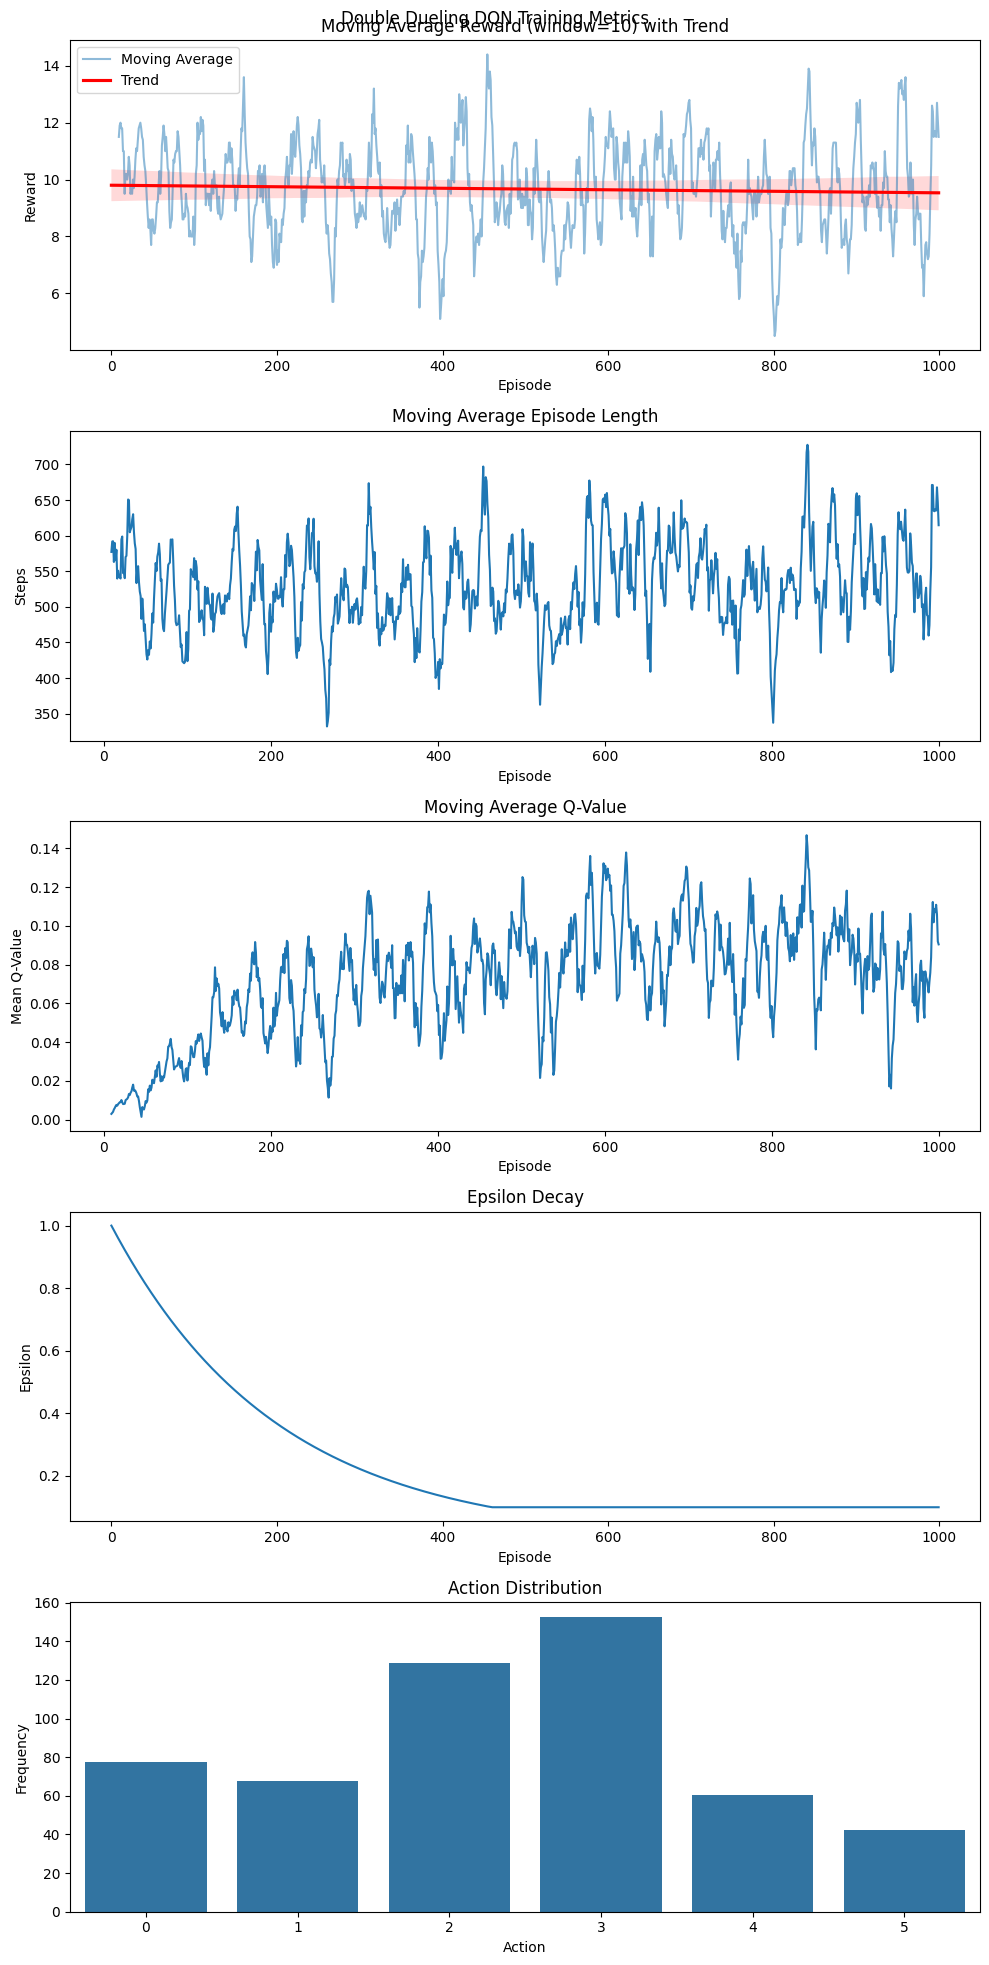


Metrics Summary:
            reward       length       mean_q      epsilon
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      9.668000   529.599000     0.071336     0.234064
std       4.905287   189.961474     0.065759     0.223425
min       0.000000   225.000000    -0.091539     0.100000
25%       6.000000   388.000000     0.020852     0.100000
50%       9.000000   498.000000     0.066328     0.100000
75%      12.000000   639.250000     0.116593     0.285967
max      30.000000  1388.000000     0.263490     1.000000


In [27]:
env = make_env()
state, _ = env.reset()
state_shape = state.shape

doubleDuelingAgent = DoubleDuelingDQNAgent(state_shape, env.action_space.n)

# Train
training_tracker = train_agent_with_warmup(doubleDuelingAgent, env, num_episodes=1000, eval_frequency=100, warmup_steps=10000)

# Plot training metrics
plot_training_metrics(training_tracker, "Double Dueling DQN Training Metrics")

## Final "optimized" run using theoretical best model

Training:  10%|█         | 250/2500 [13:42<3:57:23,  6.33s/it]


Episode 250 | Mean Eval Reward: 8.30 | Epsilon: 0.125


Training:  20%|██        | 500/2500 [36:26<2:52:04,  5.16s/it]


Episode 500 | Mean Eval Reward: 9.00 | Epsilon: 0.125


Training:  30%|███       | 750/2500 [52:05<2:37:18,  5.39s/it]


Episode 750 | Mean Eval Reward: 10.50 | Epsilon: 0.125


Training:  40%|████      | 1000/2500 [1:08:24<2:25:40,  5.83s/it]


Episode 1000 | Mean Eval Reward: 10.80 | Epsilon: 0.125


Training:  50%|█████     | 1250/2500 [1:24:09<2:09:21,  6.21s/it]


Episode 1250 | Mean Eval Reward: 9.70 | Epsilon: 0.125


Training:  60%|██████    | 1500/2500 [1:40:46<1:14:07,  4.45s/it]


Episode 1500 | Mean Eval Reward: 9.60 | Epsilon: 0.125


Training:  70%|███████   | 1750/2500 [1:57:18<1:15:01,  6.00s/it]


Episode 1750 | Mean Eval Reward: 11.90 | Epsilon: 0.125


Training:  80%|████████  | 2000/2500 [2:13:07<40:13,  4.83s/it]


Episode 2000 | Mean Eval Reward: 7.90 | Epsilon: 0.125


Training:  90%|█████████ | 2250/2500 [2:29:04<26:54,  6.46s/it]


Episode 2250 | Mean Eval Reward: 13.60 | Epsilon: 0.125


Training: 100%|██████████| 2500/2500 [2:45:29<00:00,  3.97s/it]



Episode 2500 | Mean Eval Reward: 11.90 | Epsilon: 0.125


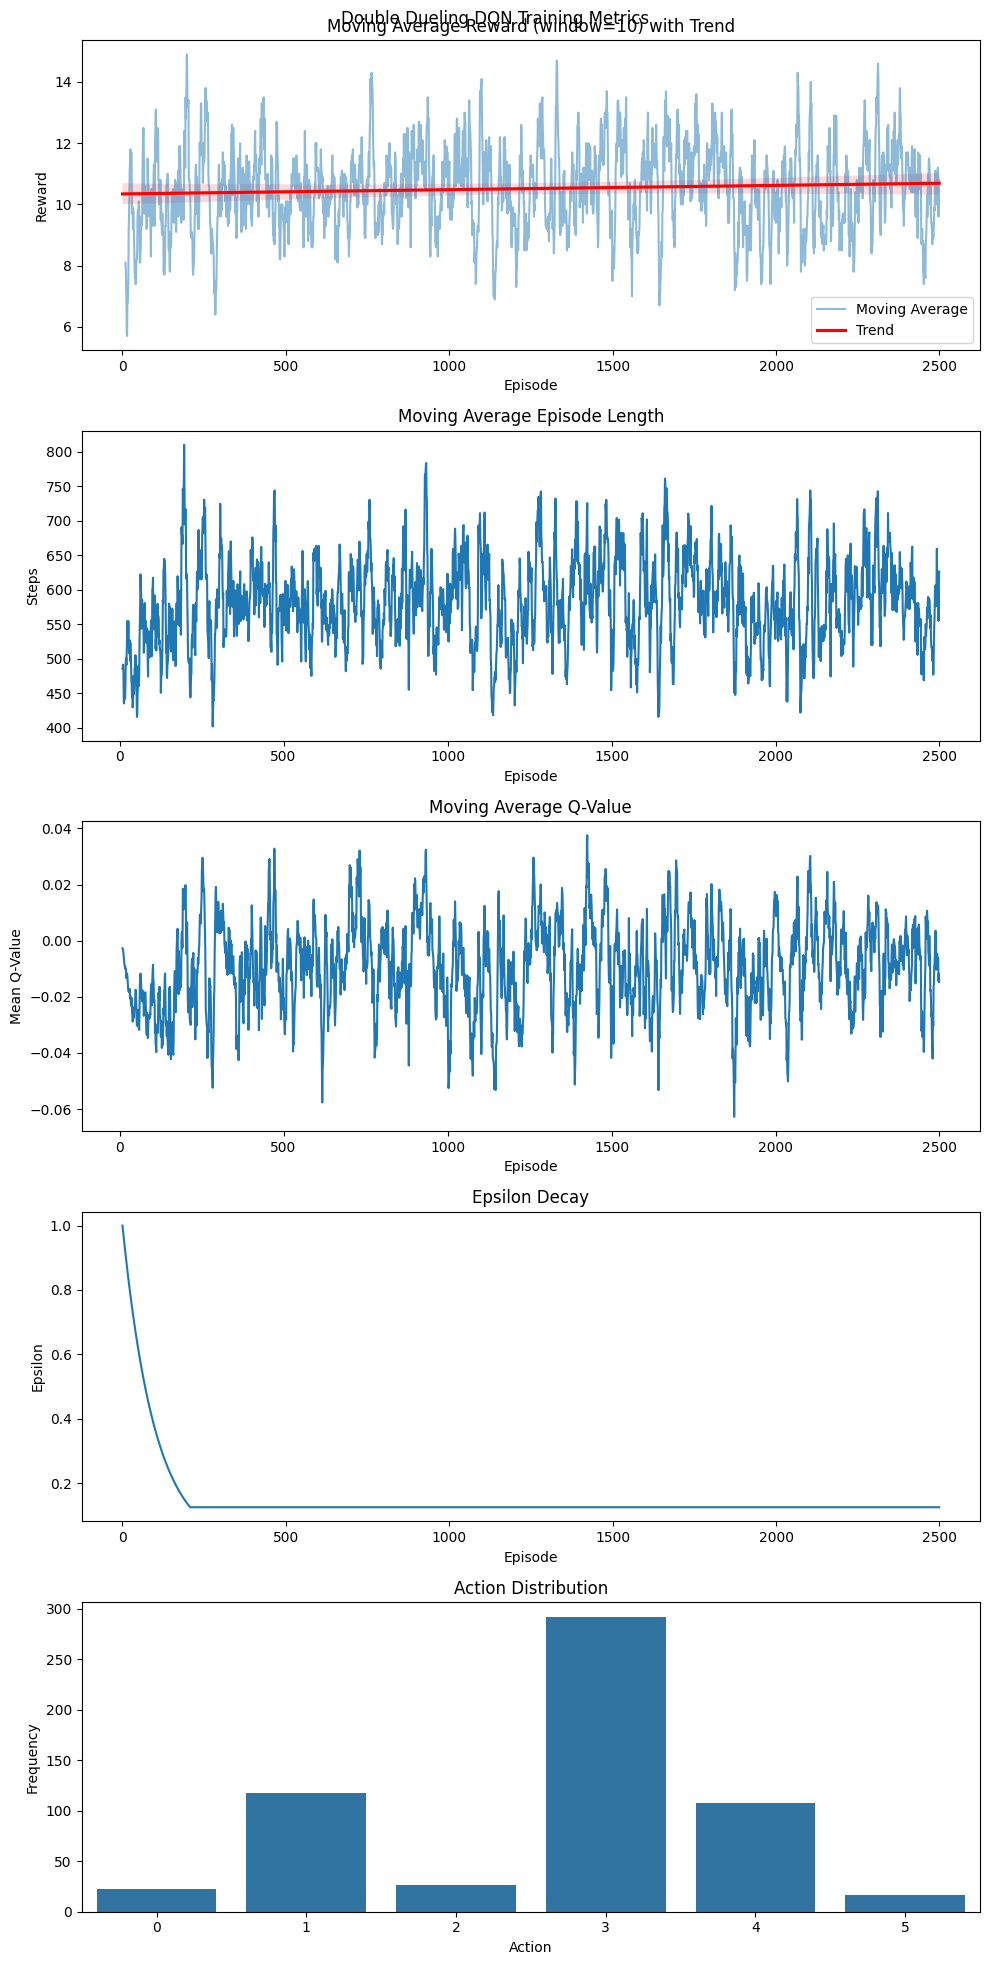


Metrics Summary:
            reward       length       mean_q      epsilon
count  2500.000000  2500.000000  2500.000000  2500.000000
mean     10.516800   582.688800    -0.009180     0.149655
std       4.502202   202.609714     0.046385     0.108289
min       0.000000   221.000000    -0.207232     0.125000
25%       7.000000   484.000000    -0.033262     0.125000
50%      10.000000   537.000000    -0.005262     0.125000
75%      13.000000   679.000000     0.020308     0.125000
max      36.000000  1551.000000     0.135864     1.000000


In [18]:
env = make_env()
state, _ = env.reset()
state_shape = state.shape

# Initialize agent with some better chosen hyperparameters
double_dueling_agent = DoubleDuelingDQNAgent(state_shape=state_shape, n_actions=env.action_space.n, lr=0.0001, memory_size=500000, batch_size=64, gamma=0.99, epsilon=1.0, epsilon_min=0.125, epsilon_decay=0.99, target_update=1000)

# Train
training_tracker = train_agent_with_warmup(double_dueling_agent, env, num_episodes=2500, eval_frequency=250, warmup_steps=10000)

# Plot training metrics
plot_training_metrics(training_tracker, "Double Dueling DQN Training Metrics")